Neural Network is a flexible to describe various nonlinear functions as known in Universal [Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem).  Neural Network is, however, generally difficult to figure out the attribution of the prediction, i.e., what part of input has significant effect on the model output. In the paper, [Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf), introduces a method called `Integrated Gradient` has been introduced. 
This method is theoretically sound and easy to implement. Let's look at the detail

which satisfies both of `Sensitivity` and `Implementation Invariance`.


# Theory

### Sensitivity and Implementation Invariance
When considering an attribution of the prediction, two properties, `Sensitivity` and `Implementation Invariance`, are considered. 

Consider a benchmark $\hat{x}$ and an input $x$. 
`Sensitivity` defines how attribution reflects difference in the input and output.
More precisely, when only one feature differs between the benchmark and the input, its attribution has to be non-zero. 


### Integrated Gradient
The idea behind `Integrated Gradient` is the property that line integral does not depend on the path if the function is [totally differentiable](https://en.wikipedia.org/wiki/Total_derivative). Practically speaking, we can assume that most of neural network satisfies this property.

Mathematically, `Integrated Gradient` is defined as
$$IntegratedGrads_i(x) = (x_i - \hat{x}_i) \times \int_{\alpha = 0}^1 \partial_i F(\hat{x} + \alpha (x - \hat{x})) d\alpha$$ 

This equation is derived through line integral. Consider the following identity
$$F(x) - F(x_0) = \int_{x_0}^x ds \cdot \nabla F(s)$$
$$= \sum_{i=1}^n \int_{x_0}^x ds_i \partial_i F(s)$$

Thus, `Integrated Gradient` can be considered as i th coordinate contribution toward the line integral. 

Due to the independence of the shape of path, `Integrated Gradient` satisfies `Sensitivity`. 

From the construction based on derivatives, we deduce that `Integrated Gradient` satisfies `Implementation Invariance`. Thus, `Integrated Gradient` satisfies both axioms.



# Implementation
When implementing `Integrated Gradient`, the integral part is approximated with discretization,
$$IntegratedGrads_i(x) \sim (x_i - \hat{x}_i) \times \frac{1}{m} \sum_{i=1}^m \partial_i F(\hat{x} + \frac{i}{m} (x - \hat{x}))$$

$m$ is usually between $20 \sim 300$.

In this article, we implement `Integrated Gradient` with PyTorch.
As a toy example, we test with MNIST.

# MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as tdata

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

For the network architecture, we use a basic CNN with batch normalization. 

In [298]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.batch1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.batch2 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(320, 50)
        self.batch3 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.relu(self.batch2(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.batch3(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, 1)

Loading MNIST data ... 

In [296]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transform),
        batch_size=batch_size, shuffle=True)
    
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=batch_size, shuffle=True)

For training, use the author's repository, [torch_utils](https://github.com/jjakimoto/PyTorch-Utils).

In [299]:
from torch_utils.training import train_step, test_step
from tqdm import tqdm_notebook

model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for i in tqdm_notebook(range(100)):
    train_step(model, train_loader, optimizer,
               epoch=i, log_interval=1000)
    test_step(model, test_loader)

HBox(children=(IntProgress(value=0), HTML(value='')))

Train Epoch: 0                    [(0, 0)/60000                    (0.0%)]	Loss: 2.31086802482605
Train Epoch: 0                    [(0, 32000)/60000                    (53.333333333333336%)]	Loss: 0.4003725051879883

Test set: Average loss: 0.061662356785684824,           Accuracy: 9819/10000           (98.19%)

Train Epoch: 1                    [(1, 0)/60000                    (0.0%)]	Loss: 0.3734539747238159
Train Epoch: 1                    [(1, 32000)/60000                    (53.333333333333336%)]	Loss: 0.07642634212970734

Test set: Average loss: 0.050340010657720265,           Accuracy: 9836/10000           (98.36%)

Train Epoch: 2                    [(2, 0)/60000                    (0.0%)]	Loss: 0.15327776968479156
Train Epoch: 2                    [(2, 32000)/60000                    (53.333333333333336%)]	Loss: 0.08972733467817307

Test set: Average loss: 0.040499439201131464,           Accuracy: 9881/10000           (98.81%)

Train Epoch: 3                    [(3, 0)/60000 


Test set: Average loss: 0.02903967463537374,           Accuracy: 9915/10000           (99.15%)

Train Epoch: 26                    [(26, 0)/60000                    (0.0%)]	Loss: 0.010499436408281326
Train Epoch: 26                    [(26, 32000)/60000                    (53.333333333333336%)]	Loss: 0.13625697791576385

Test set: Average loss: 0.027420198012412585,           Accuracy: 9915/10000           (99.15%)

Train Epoch: 27                    [(27, 0)/60000                    (0.0%)]	Loss: 0.0577792264521122
Train Epoch: 27                    [(27, 32000)/60000                    (53.333333333333336%)]	Loss: 0.09584437310695648

Test set: Average loss: 0.02901151145563199,           Accuracy: 9914/10000           (99.14%)

Train Epoch: 28                    [(28, 0)/60000                    (0.0%)]	Loss: 0.09507016837596893
Train Epoch: 28                    [(28, 32000)/60000                    (53.333333333333336%)]	Loss: 0.030267730355262756

Test set: Average loss: 0.02843

Train Epoch: 51                    [(51, 32000)/60000                    (53.333333333333336%)]	Loss: 0.0059344470500946045

Test set: Average loss: 0.030843802622269868,           Accuracy: 9923/10000           (99.23%)

Train Epoch: 52                    [(52, 0)/60000                    (0.0%)]	Loss: 0.010564781725406647
Train Epoch: 52                    [(52, 32000)/60000                    (53.333333333333336%)]	Loss: 0.05927424505352974

Test set: Average loss: 0.030679912087154298,           Accuracy: 9922/10000           (99.22%)

Train Epoch: 53                    [(53, 0)/60000                    (0.0%)]	Loss: 0.001768331159837544
Train Epoch: 53                    [(53, 32000)/60000                    (53.333333333333336%)]	Loss: 0.06976345181465149

Test set: Average loss: 0.03599048922897304,           Accuracy: 9909/10000           (99.09%)

Train Epoch: 54                    [(54, 0)/60000                    (0.0%)]	Loss: 0.09719540923833847
Train Epoch: 54             


Test set: Average loss: 0.03261369605401087,           Accuracy: 9924/10000           (99.24%)

Train Epoch: 77                    [(77, 0)/60000                    (0.0%)]	Loss: 0.0008544030715711415
Train Epoch: 77                    [(77, 32000)/60000                    (53.333333333333336%)]	Loss: 0.015620199032127857

Test set: Average loss: 0.03365778045428731,           Accuracy: 9923/10000           (99.23%)

Train Epoch: 78                    [(78, 0)/60000                    (0.0%)]	Loss: 0.002567847492173314
Train Epoch: 78                    [(78, 32000)/60000                    (53.333333333333336%)]	Loss: 0.0015074843540787697

Test set: Average loss: 0.031240790305914243,           Accuracy: 9923/10000           (99.23%)

Train Epoch: 79                    [(79, 0)/60000                    (0.0%)]	Loss: 9.423063602298498e-05
Train Epoch: 79                    [(79, 32000)/60000                    (53.333333333333336%)]	Loss: 0.0023143950384110212

Test set: Average loss

Next, we implement `Integrated Gradient`.
It requires only gradient of the model output with respect to the input.

In [376]:
import numpy as np
from torch.autograd import Variable


def get_gradient_output(model, inputs, output_idx=0, device='cpu'):
    '''Get gradient of output with resepct to input

    Parameters
    ----------
    model: nn.Module subclass
    inputs: torch.tensor
        input with shape = (n_batch,) + input_dim
    output_idx: int or array-like, (default 0)
        index of output to calculate gradients
    device: str, (default 'cpu')
    
    Returns
    -------
    grads: torch.tensor
        input with shape = (n_batch,) + input_dim
    outputs: torch.tensor 
        outputs with shape = (n_batch,) + input_dim[:-1]
    '''
    model.eval()
    n_batch = inputs.size(0)
    if np.issubdtype(type(output_idx), np.integer):
        output_idx = [output_idx for _ in range(n_batch)]
    output_list = []
    grad_list = []
    for i in range(n_batch):
        model.zero_grad()
        input_var = Variable(inputs[[i]], requires_grad=True)
        output = model(input_var)[0][output_idx[i]]
        output.backward()
        output_list.append(output)
        grad_list.append(input_var.grad[0])
    grads = torch.stack(grad_list).detach().numpy()
    outputs = torch.stack(output_list).detach().numpy()
    return grads, outputs

def integrated_gradients(model, input, output_idx=None, baseline=None, steps=50, device='cpu'):
    '''Get integrated gradients

    Parameters
    ----------
    model: nn.Module subclass
    input: torch.tensor
        input without batch dimension, i.e., shape = input_dim
    output_idx: int, optional
        output_idx to calculate gradients
        If not specified, use the highest value output index
    baseline: torch.tensor, optional
        The shape is the same as that of input
        If not specified, zero tensor is used
    steps: int
        The number to use for calculating integral
    device: str, (default 'cpu')
    
    Returns
    -------
    grads: torch.tensor
        input with shape = (n_batch,) + input_dim
    outputs: torch.tensor 
        outputs with shape = (n_batch,) + input_dim[:-1]
    '''
    if baseline is None:
        baseline = 0. * input
    assert(baseline.shape == input.shape)
    if output_idx is None:
        input_ = torch.stack([input])
        output = model(input_)
        output_idx = output.max(1)[1][0]
    # Scale input and compute gradients.
    scaled_inputs = [baseline + (float(i) / steps) * (input - baseline) for i in range(0, steps+1)]
    scaled_inputs = torch.stack(scaled_inputs)
    grads, outputs = get_gradient_output(model, scaled_inputs, output_idx, device)
    mean_grads = np.mean(grads, axis=0)
    integrated_gradients = (input.numpy() - baseline.numpy()) * mean_grads
    output = outputs[-1]
    return integrated_gradients, output

We sample examples for each class from 0 to 9.

In [377]:
test_data = {}
for X, y in test_loader:
    output = model(X)
    pred_val, pred_idx = output.max(1)
    flag = torch.eq(pred_idx, y)
    y = y[flag]
    pred_val = pred_val[flag]
    X = X[flag]
    for conf, X_i, y_i in zip(pred_val, X, y):
        val = test_data.get(y_i.item(), None)
        if val is None:
            test_data[y_i.item()] = (conf.item(), X_i)
        else:
            if conf.item() > val[0]:
                test_data[y_i.item()] = (conf.item(), X_i)

First, we consider using default zero baseline.

In [378]:
results = dict()
for idx, test_item in test_data.items():
    X = test_item[1]
    grads, output = integrated_gradients(model, X, output_idx=idx)
    results[idx] = (X[0].numpy(), grads[0])

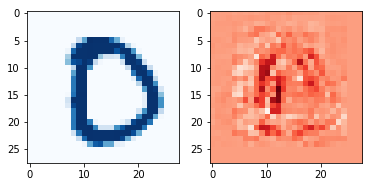

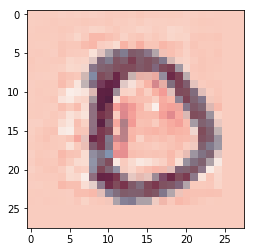

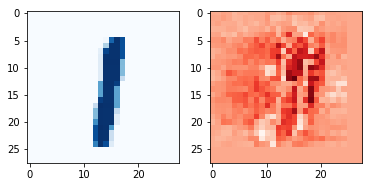

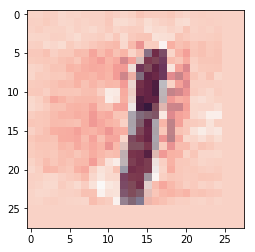

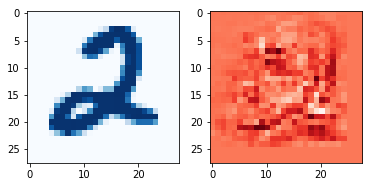

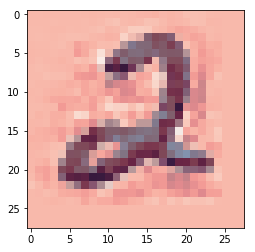

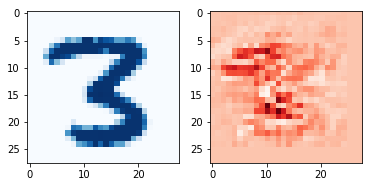

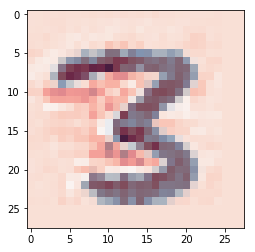

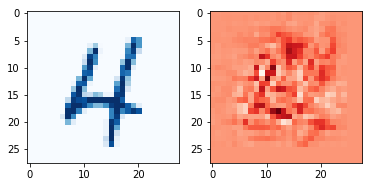

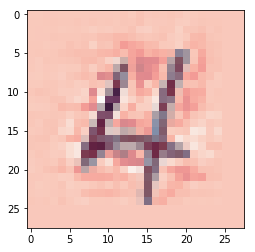

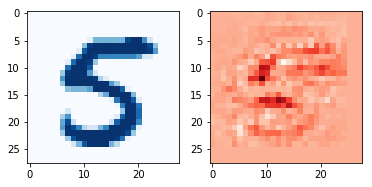

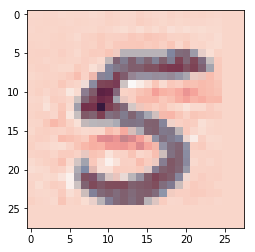

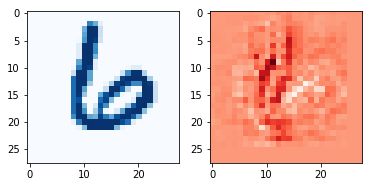

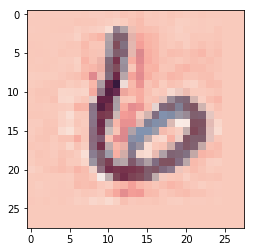

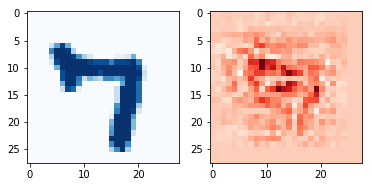

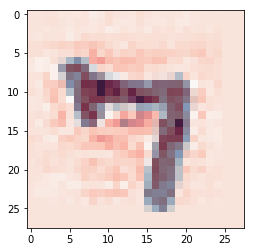

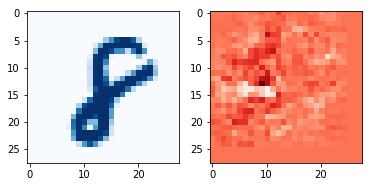

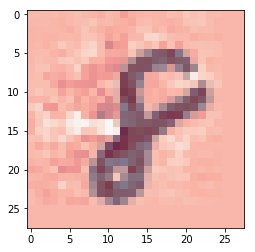

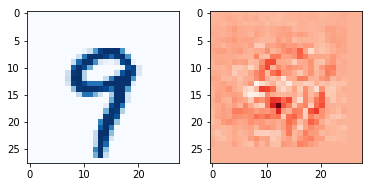

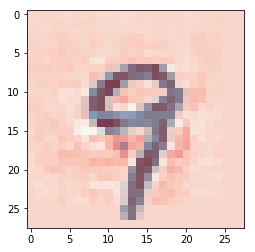

In [379]:
import matplotlib.pyplot as plt
%matplotlib inline


for idx in range(10):
    # Clense attributes for visualization
    attr = results[idx][1]
    # attr[attr == 0] = -np.inf
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(results[idx][0], cmap='Blues')
    ax[1].imshow(attr, cmap='Reds', alpha=1)
    plt.figure()
    plt.imshow(results[idx][0], cmap='Blues')
    plt.imshow(attr, cmap='Reds', alpha=.5)

You can see that pixels located at the edge of each number has high attributions.

Next, we pick 0 as a benchmark. 

In [380]:
results = dict()
baseline = test_data[0][1]
for idx, test_item in test_data.items():
    X = test_item[1]
    grads, output = integrated_gradients(model, X, output_idx=idx,
                                         baseline=baseline)
    results[idx] = (X[0].numpy(), grads[0])

/home/tom/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/tom/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:710: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


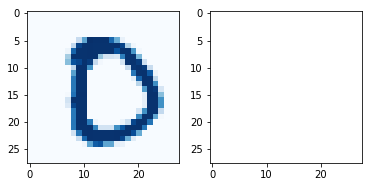

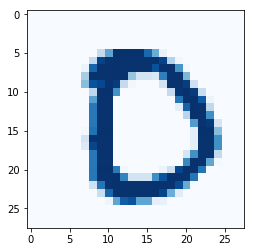

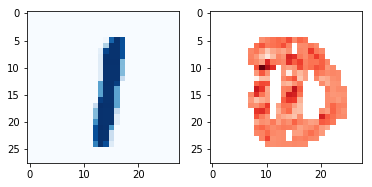

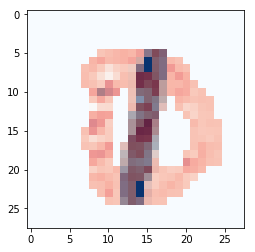

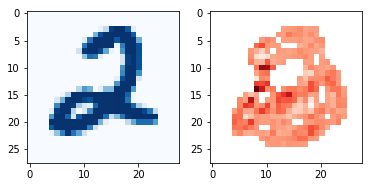

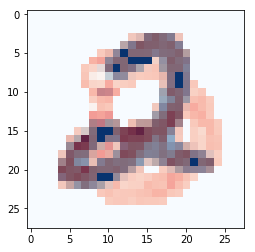

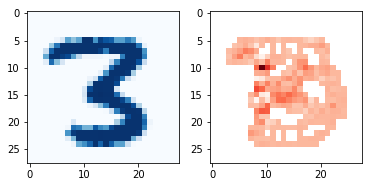

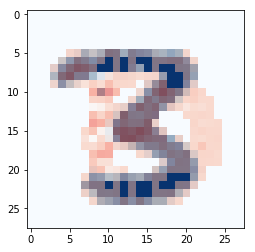

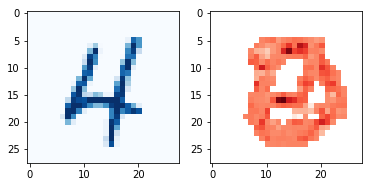

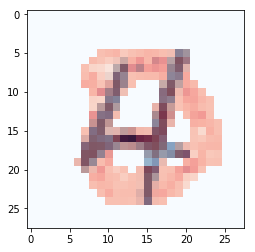

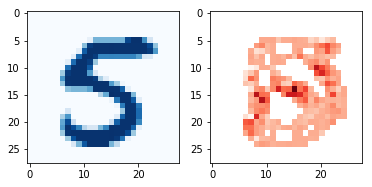

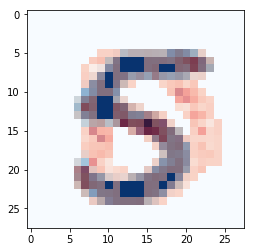

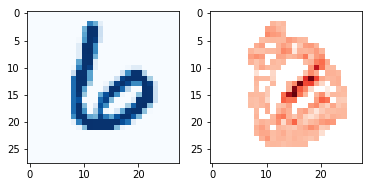

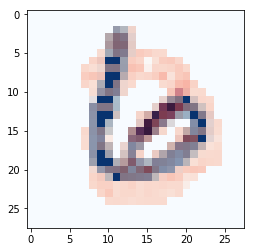

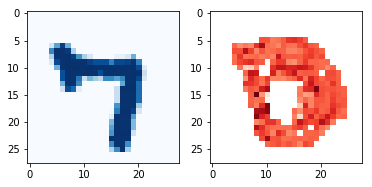

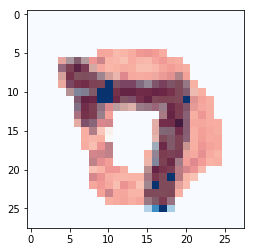

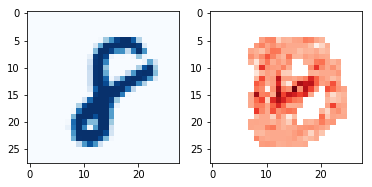

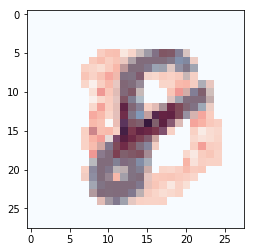

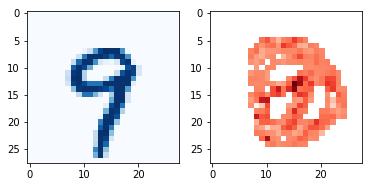

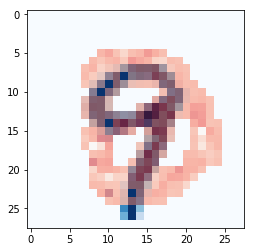

In [381]:
for idx in range(10):
    # Clense attributes for visualization
    attr = results[idx][1]
    attr[attr == 0] = -np.inf
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(results[idx][0], cmap='Blues');
    ax[1].imshow(attr, cmap='Reds', alpha=1);
    plt.figure()
    plt.imshow(results[idx][0], cmap='Blues');
    plt.imshow(attr, cmap='Reds', alpha=.5);

More vividly, we can see that the part of each number and bench mark 0 are used for predictions.

# Wrap Up

`Integrated Gradient` is easy to implement and holds theoretically grantee properties. This tool would be help ful to research something.